## 1.导入需要的包

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import warnings
%matplotlib inline

## 2.忽略无用警告

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

## 3.导入数据集

In [3]:
train = pd.read_csv('../../data/house_train.csv')
test = pd.read_csv('../../data/house_test.csv')

## 4.数据预处理

### 4.1查看价格分布情况并打印偏度和峰度

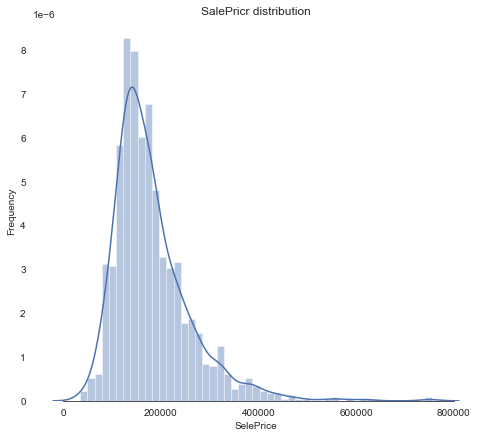

In [4]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SelePrice')
ax.set(title='SalePricr distribution')
sns.despine(trim=True, left=True)
plt.show()

In [5]:
print('Skewness: %f' % train['SalePrice'].skew())  # 偏度
print('Kurtosis: %f' % train['SalePrice'].kurt())  # 峰度

Skewness: 1.882876
Kurtosis: 6.536282


### 4.2找出数值特征

In [6]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms', 'Total_porch_sf', 
                 'haspool', 'hasgarage', 'hasbsmt', 'hasfireplace']:
            pass
        else:
            numeric.append(i)

### 4.3显示数据分布,找出异常值

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl', 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if (feature == 'MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', 
                    palette='Blues', data=train)
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='best', prop={'size': 10})
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 864x8640 with 0 Axes>

### 4.4查看相关系数

In [ ]:
corr = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap='Blues', square=True)

data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=45)

### 4.5查看特征和价格的关系

In [ ]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0, 800000))

data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0, 800000))

data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0, 800000))

### 4.6删除Id

In [ ]:
train_id = train['Id']
test_id = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

### 4.7价格右偏, 用log(1+x)调整

In [ ]:
train['SalePrice'] = np.log1p(train['SalePrice'])

### 4.8查看调整后的分布情况

In [ ]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], fit=norm, color='b')

### 4.9得到拟合参数

In [ ]:
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

### 4.10调整前后对比

In [ ]:
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sig\
ma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

### 4.11删除异常值

In [ ]:
train.drop(train[(train['OverallQual'] < 5) & 
                 (train['SalePrice'] > 200000)].index, inplace=True)
train.drop(train[(train['GrLivArea'] > 4500) & 
                 (train['SalePrice'] < 30000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

### 4.12划分训练集和测试集

In [ ]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

### 4.13确定缺失值的阈值

In [ ]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    return dict_x

### 4.14缺失数据百分比

In [ ]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print(df_miss[0:10])

### 4.15缺失数据百分比可视化

In [ ]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

ax.xaxis.grid(False)
ax.set(ylabel='Percent of missing values')
ax.set(xlabel='Features')
ax.set(title='Percent missing data by feature')
sns.despine(trim=True, left=True)

### 4.16转为字符串类型

In [ ]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

### 4.17填补缺失值

In [ ]:
def handle_missing(features):
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna('SBrkr')
    features['KitchenQual'] = features['KitchenQual'].fillna('TA')
    features['Exterior1st'] = features['Exterior\
    1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exter\
    ior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['Sale\
    Type'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZon\
    ing'].transform(lambda x: x.fillna(x.mode()[0]))

    features['PoolQC'] = features['PoolQC'].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
    features['LotFrontage'] = features.groupby('Neighb\
    orhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features


all_features = handle_missing(all_features)

### 4.18查看是否还有缺失值

In [ ]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print(df_miss[0:10])

### 4.19找出所有数值特征

In [ ]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

### 4.20为所有数字特性创建框图

In [ ]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=all_features[numeric], orient='h', palette='Set1')
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

### 4.21找出偏度大于0.5的特征

In [ ]:
skew_features = all_features[numeric].apply(lambda x: skew(x)).\
sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print('Skew > 0.5 :'.format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)

### 4.22正则化偏移特征

In [ ]:
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

### 4.23查看是否所有偏移特征都处理完毕

In [ ]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=all_features[skew_index], orient='h', palette='Set1')
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

### 4.24创造新特征

In [ ]:
all_features['BsmtFinType1_Unf'] = 1 * (all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSo\
ld'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['Overal\
lQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC', ], axis=1)
all_features['TotalSF'] = all_features['TotalB\
smtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBu\
ilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] +
                                     all_features['BsmtFinSF2'] +
                                     all_features['1stFlrSF'] +
                                     all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] +
                                   (0.5 * all_features['HalfBath']) +
                                   all_features['BsmtFullBath'] +
                                   (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] +
                                  all_features['3SsnPorch'] +
                                  all_features['EnclosedPorch'] +
                                  all_features['ScreenPorch'] +
                                  all_features['WoodDeckSF'])

all_features['TotalBsmtSF'] = all_features['TotalB\
smtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndF\
lrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['Gara\
geArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['Garag\
eCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFr\
ontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnr\
Area'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtF\
inSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['Poo\
lArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2nd\
FlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['Garage\
Area'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBs\
mtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Firep\
laces'].apply(lambda x: 1 if x > 0 else 0)

### 4.25用数值特征的对数来创建新特征

In [ ]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01 + res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res


log_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
                'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
                'YearRemodAdd', 'TotalSF']

all_features = logs(all_features, log_features)

### 4.26用数值特征的平方来创建新特征

In [ ]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] * res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res


squared_features = ['YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', 
                    '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log', 
                    'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

### 4.27编码分类特征

In [ ]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)

### 4.28删除重复的列名

In [ ]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

### 4.29划分训练集和测试集

In [ ]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

### 4.30设置交叉验证

In [ ]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

### 4.31定义误差指标

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels,
                                    scoring='neg_mean_squared_error', cv=kf))
    return (rmse)

## 5.搭建模型

### 5.1轻量梯度提升机

In [ ]:
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=6,
                         learning_rate=0.01,
                         n_estimators=7000,
                         max_bin=200,
                         bagging_fraction=0.8,
                         bagging_freq=4,
                         bagging_seed=8,
                         feature_fraction=0.2,
                         feature_fraction_seed=8,
                         min_sum_hessian_in_leaf=11,
                         verbose=-1,
                         random_state=42)

### 5.2xgboost

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

### 5.3岭回归

In [ ]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 
                1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

### 5.4支持向量机

In [ ]:
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

### 5.5梯度提升树

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

### 5.6随机森林

In [ ]:
rf = RandomForestRegressor(n_estimators=1200,
                           max_depth=15,
                           min_samples_split=5,
                           min_samples_leaf=5,
                           max_features=None,
                           oob_score=True,
                           random_state=42)

### 5.7融合多个模型

In [ ]:
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## 6.打印各模型的交叉验证分数

In [ ]:
scores = {}
score = cv_rmse(lightgbm)
print('lightgbm: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['lgb'] = (score.mean(), score.std())
score = cv_rmse(xgboost)
print('xgboost: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['xgb'] = (score.mean(), score.std())
score = cv_rmse(svr)
print('SVR: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['svr'] = (score.mean(), score.std())
score = cv_rmse(ridge)
print('ridge: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['ridge'] = (score.mean(), score.std())
score = cv_rmse(rf)
print('rf: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['rf'] = (score.mean(), score.std())
score = cv_rmse(gbr)
print('gbr: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [ ]:
scores['gbr'] = (score.mean(), score.std())
print('stack_gen')

In [ ]:
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))
print('lightgbm')

In [ ]:
lgb_model_full_data = lightgbm.fit(X, train_labels)
print('xgboost')

In [ ]:
xgb_model_full_data = xgboost.fit(X, train_labels)
print('Svr')

In [ ]:
svr_model_full_data = svr.fit(X, train_labels)
print('Ridge')

In [ ]:
ridge_model_full_data = ridge.fit(X, train_labels)
print('RandomForest')

In [ ]:
rf_model_full_data = rf.fit(X, train_labels)
print('GradientBoosting')

In [ ]:
gbr_model_full_data = gbr.fit(X, train_labels)

### 6.1混合模型

In [ ]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) +
            (0.2 * svr_model_full_data.predict(X)) +
            (0.1 * gbr_model_full_data.predict(X)) +
            (0.1 * xgb_model_full_data.predict(X)) +
            (0.1 * lgb_model_full_data.predict(X)) +
            (0.05 * rf_model_full_data.predict(X)) +
            (0.35 * stack_gen_model.predict(np.array(X))))

### 6.2打印混合模型结果

In [ ]:
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

### 6.3模型分数可视化

In [ ]:
sns.set_style('white')
fig = plt.figure(figsize=(24, 12))
ax = sns.pointplot(x=list(scores.keys()), 
                   y=[score for score, _ in scores.values()], 
                   markers=['o'], 
                   linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6}'.format(score[0]), 
            horizontalalignment='left', size='large', 
            color='black', weight='semibold')
plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)
plt.title('Scores of Models', size=20)
plt.show()

In [ ]:
submission = pd.read_csv('../../data/sample_submission.csv')
submission.iloc[:, 1] = np.floor(np.expm1(blended_predictions(X_test)))

### 6.4矫正预测

In [ ]:
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SaleP\
rice'].apply(lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['Sale\
Price'].apply(lambda x: x if x < q2 else x * 1.1)
submission.to_csv('submission_regression1.csv', index=False)

### 6.5规模预测

In [ ]:
submission['SalePrice'] *= 1.001619
submission.to_csv('submission_regression2.csv', index=False)